In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from scipy.signal import medfilt
from statistics import mean, median

import os
from classify import classify

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, fs, cutoff, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_bandpass(cutoff_l, cutoff_h, fs, order=5):
    nyq = 0.5 * fs
    b, a = signal.butter(order, [cutoff_l/nyq, cutoff_h/nyq], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, fs, cutoff_l, cutoff_h, order=5):
    b, a = butter_bandpass(cutoff_l, cutoff_h, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [ ]:


plt.style.use("opinionated_m")

font = {'weight': 'normal'}

# Apply the font properties
plt.rc('font', **font)

In [ ]:
def numpy_array_encoder(arr):
    if isinstance(arr, np.ndarray):
        return arr.tolist()  
    else:
        raise TypeError("Object of type '{}' is not JSON serializable".format(type(arr)))
        
def unique_elements_in_order(arr1, arr2):
    combined_arr = np.concatenate((arr1, arr2))
    
    unique_elements, indices = np.unique(combined_arr, return_index=True)
    
    sorted_unique_elements = unique_elements[np.argsort(indices)]
    
    return sorted_unique_elements

def dataframe_to_np_array_and_subtract(df, value):
    numerical_columns = df.select_dtypes(include=[np.number]).columns

    np_array = df.values.copy()

    for col in numerical_columns:
        col_index = df.columns.get_loc(col)
        np_array[:, col_index] -= value

    return np_array

In [ ]:
FS = 128
thresh_mult = FS/100
bns = 30
skip = 3
out_dir = 'alt_process/'

In [ ]:
def minus_cubic(p, prom):
    peaks = peakfind_ppg(p, prominence=prom)
    
    x = np.arange(0, len(p) / FS, 1/FS)
    line = interpolate.CubicSpline(x[peaks], p[peaks])
    
    return p - line(x)
    
def get_prominence(p, fs):
    bpfed = butter_bandpass_filter(p, fs, 0.8, 3.5)
    bpfed -= min(bpfed)
    
    return median(bpfed)/3
    
def peakfind_ppg(x, distance=40, prominence=200):
    peaks, _ = signal.find_peaks(x, distance=distance, prominence=prominence)
    return peaks

def peakfind_quick(x):
    return np.argmax(x)

def generate_indices(px, pres):
    def t100(sig):
        return signal.resample(sig, 100)
    
    prm = get_prominence(px, FS)
    
    pp = peakfind_ppg(-1 * px, distance=40*thresh_mult, prominence = prm/5)
    save_idxs = []
    
    tolerance = prm/10

    max_in = len(pp)
    
    last_len = None
    length_tolerance = 0.35
    
    for i in range(1, max_in):
        
        # Check Length
        if 110 * thresh_mult > pp[i] - pp[i-1] > 40 * thresh_mult:
            
            if last_len is None:
                last_len = pp[i] - pp[i-1]
            else:
                if pp[i] - pp[i-1] < (1 + length_tolerance) * last_len and \
                    pp[i] - pp[i-1] > (1 - length_tolerance) * last_len:
                    
                    last_len = pp[i] - pp[i-1]

                    # Check the feet are reasonably at 0
                    if abs(px[pp[i-1]]) < tolerance and abs(px[pp[i]]) < tolerance and \
                        min(px[pp[i-1]:pp[i]]) >= -1 * tolerance:

                        save_idxs.append([pp[i-1], pp[i], 
                                             classify(t100(px[pp[i-1]: pp[i]])),
                                            mean(pres[pp[i-1]: pp[i]])])

    return save_idxs

In [ ]:
dfbio = pd.read_csv('Biodata.csv')

dfbio

,ID,H,W,Age,Gender,BMI
0,1000,163,62,24,M,23.335466
1,1001,155,42,23,F,17.481790
2,1002,167,50,23,F,17.928215
3,1003,165,58,27,M,21.303949
4,1004,170,70,25,M,24.221453
5,1005,172,57,24,M,19.267171
6,1007,173,70,24,M,23.388687
7,1008,166,58,24,M,21.048048
8,1009,197,63,24,M,16.233348
9,1010,175,53,22,M,17.306122


In [ ]:
def r128hz(sig):
    return signal.resample(sig, (len(sig) * 128) // 100)

def check_max_1_not_2L(arr):
    count_not = np.sum(arr != '2L')
    count_2L = np.sum(arr == '2L')
    return count_not <= 1 and count_not + count_2L == len(arr)

def check_max_2_not_2L(arr):
    count_not = np.sum(arr != '2L')
    count_2L = np.sum(arr == '2L')
    return count_not <= 2 and count_not + count_2L == len(arr)

def check_max_1_not_2L_not_3(arr):
    count_not = np.sum((arr != '2L') & (arr != '3'))
    count_2L = np.sum(arr == '2L')
    return count_not <= 1 and count_not + count_2L == len(arr)

def check_max_2_not_2L_not_3(arr):
    count_not = np.sum((arr != '2L') & (arr != '3'))
    count_2L = np.sum(arr == '2L')
    return count_not <= 2 and count_not + count_2L == len(arr)

def check_max_1_1L(arr):
    count_1L = np.sum(arr == '1L')
    count_2L = np.sum(arr == '2L')
    return count_1L <= 1 and count_1L + count_2L == len(arr)

def check_max_2_1L(arr):
    count_1L = np.sum(arr == '1L')
    count_2L = np.sum(arr == '2L')
    return count_1L <= 2 and count_1L + count_2L == len(arr)

def check_all_2L(arr):
    return np.all(arr == '2L')

def check_all_1L(arr):
    count_1L = np.sum(arr == '1L')
    count_2L = np.sum(arr == '2L')
    return count_1L + count_2L == len(arr)

In [ ]:
t_idxs = []

In [ ]:
for index, row in dfbio.iterrows():    
    dr = 'S' + str(row['ID'])
    dfs = [file for file in os.listdir(dr) if 'preprocessed_' in file]

    indices = None

    for x in range(len(dfs)):
        FILE_NAME = dr + '_' + str(x)
        df = pd.read_csv(dr + '/' + dfs[x])
        
        if indices is None:
            indices = pd.DataFrame(generate_indices(df['PPG_In_AC'], medfilt(df['Pressure_In'], kernel_size=151)),  
                columns = ['s', 'e', 't', 'p'])
        else:
            indices = pd.concat([indices, pd.DataFrame(generate_indices(df['PPG_In_AC'], df['Pressure_In']), 
                columns = ['s', 'e', 't', 'p'])])
    t_idxs.append(indices)          

1282
1669
1261
1055
1594
1460
2162
1381
1621
1378
1043
1854
1364
609
1199
1627
1538
1603
1305
1058
1882
1245
2288
1566
1271
1154
1765
1684
1456
969


In [ ]:
print(t_idxs[0])

        s      e   t           p
0     430    508   1   97.863826
1     508    584  2E  112.587556
2     584    662  2E  124.269718
3     662    739   1  128.691090
4     887    967   1   97.898755
..    ...    ...  ..         ...
36  17493  17566  2E  493.140151
37  17566  17644   1   80.056124
38  17644  17721   1   98.115091
39  17721  17800   1  100.160049
40  17800  17880   1  101.688673

[1282 rows x 4 columns]


Let P1 be min, let P2 be optimum, let P3 be max

In [ ]:
alltypes = ["1", "1L", "2E", "2L", "3"]

In [ ]:
def sum_of_lists(dictionary):
    result_list = []
    for value in dictionary.values():
        for i, val in enumerate(value):
            if i < len(result_list):
                result_list[i] += val
            else:
                result_list.append(val)
    return result_list

def remove_3sd(dataframe):
    mean = dataframe['p'].mean()
    std_dev = dataframe['p'].std()
    
    upper_threshold = mean + 3 * std_dev
    lower_threshold = mean - 3 * std_dev
    
    filtered_df = dataframe[(dataframe['p'] >= lower_threshold) & (dataframe['p'] <= upper_threshold)]
    
    return filtered_df

def count_types(df):
    types = ["1", "1L", "2E", "2L", "3"]

    grouped = df.groupby('pb')

    counts_2d_array = [
        group['t'].value_counts().reindex(types, fill_value=0).tolist()
        for _, group in grouped
    ]

    while len(counts_2d_array) < bns:
        counts_2d_array.append([0,0,0,0,0])
    
    return np.array(counts_2d_array)

def normalize_2d_array(array):
    row_sums = array.sum(axis=1)
    row_sums = np.where(row_sums == 0, 1, row_sums)
    
    normalized_array = array / row_sums[:, np.newaxis]
    
    return normalized_array

In [ ]:
minmaxcps = []

def p1p3norm(ti):
    total_normalised = None
    for n, t in enumerate(ti):
        cpy_t = t.copy()
        cpy_t = remove_3sd(cpy_t)

        min_p = min(cpy_t['p'])
        max_p = max(cpy_t['p'])

        minmaxcps.append([min_p, max_p])

        cpy_t['p'] -= min_p
        cpy_t['p'] /= max_p

        bins = np.linspace(0, 1, bns + 1)

        cpy_t['pb'] = pd.cut(cpy_t['p'], bins=bins, labels=False, right=True)

        normed = normalize_2d_array(count_types(cpy_t)).T

        if total_normalised is None:
            total_normalised = normed
        else:
            total_normalised += normed
    
    return total_normalised

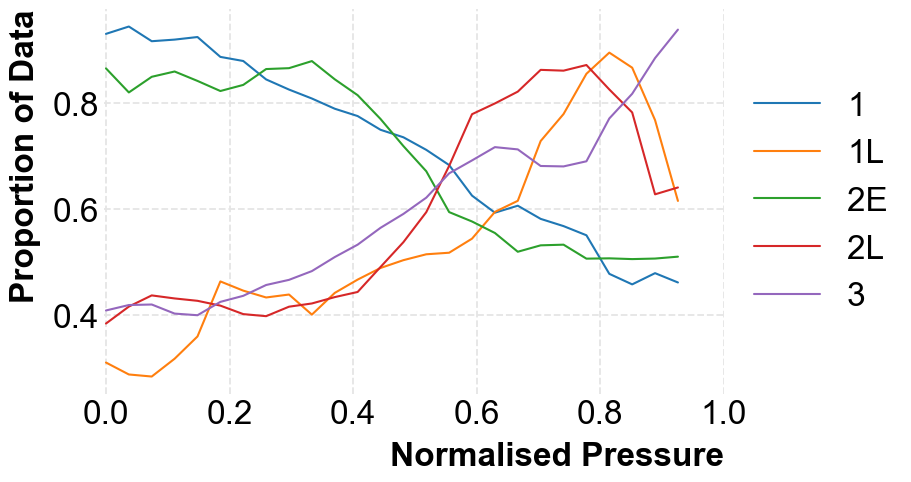

In [ ]:
p1p3a = p1p3norm(t_idxs)

column_sums = p1p3a.sum(axis=0)

p1p3 = p1p3a / column_sums

labels = ["1", "1L", "2E", "2L", "3"]

fig, ax = plt.subplots(figsize=(8, 5))

p1p3b = p1p3 / p1p3.max(axis=1, keepdims=True)

window_size = 4

smoothed_array = np.apply_along_axis(lambda row: np.convolve(row, np.ones(window_size) / window_size, mode='valid'), axis=1, arr=p1p3b)

for i, row in enumerate(smoothed_array):
    ax.plot(row[:-1], label=labels[i])
    
ax.set_xlabel('Normalised Pressure', fontsize=24)
ax.set_ylabel('Proportion of Data', fontsize=24)

ax.set_xlim(-0.1, 1)

xticks_range = np.linspace(0, bns - skip, num=6)

xticks_labels = np.linspace(0, 1, num=6)

ax.set_xticks(xticks_range)

ax.set_xticklabels(np.round(xticks_labels, 2)) 
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.legend(loc='center left', fontsize=24, bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
def cumulative_sum(input_list):
    running_sum = 0
    return [running_sum := running_sum + num for num in input_list]

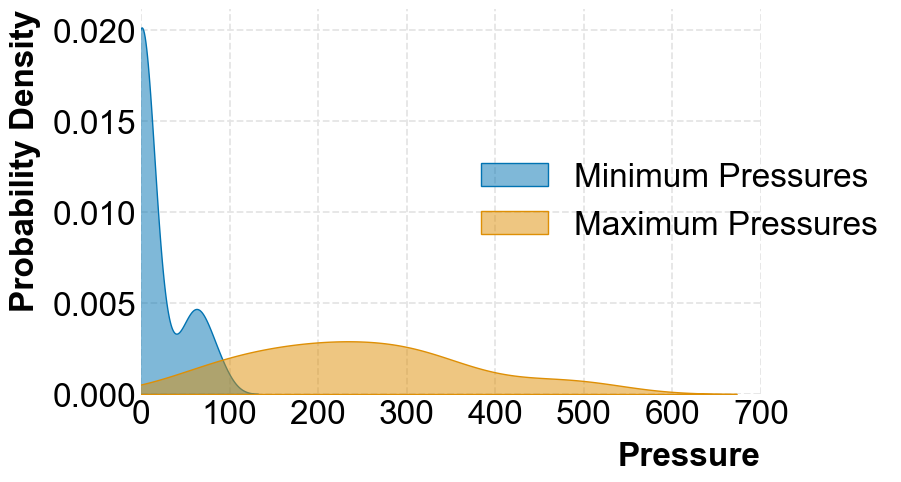

In [ ]:
import seaborn as sns

col1 = [row[0] for row in minmaxcps]
col2 = [row[1] for row in minmaxcps]
colors = sns.color_palette("colorblind")


plt.figure(figsize=(8, 5))

sns.kdeplot(col1, label='Minimum Pressures', fill=True, color=colors[0], alpha=0.5)
sns.kdeplot(col2, label='Maximum Pressures', fill=True, color=colors[1], alpha=0.5)

plt.xlabel('Pressure', fontsize=24)
plt.ylabel('Probability Density', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks([0, 0.005, 0.01, 0.015, 0.02], fontsize=24)
plt.xlim(0, 700)
plt.legend(loc='center left', fontsize=24, bbox_to_anchor=(0.5, 0.5))

plt.show()